# Fixing the OAH processing

### Imports

<ipython-input-1-9d00cfab4637>:37: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


<IPython.core.display.Javascript object>


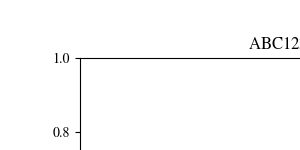

In [1]:
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.widgets import Slider
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
import scipy.odr as odr
import imageio
import gc
from matplotlib.widgets import EllipseSelector, RectangleSelector
from matplotlib.pyplot import cm
from scipy.special import eval_legendre
from scipy.optimize import curve_fit
import scipy.fftpack as fft
from matplotlib.colors import LogNorm
import csv
import random 
from scipy.signal.windows import tukey
from skimage.restoration import unwrap_phase
from matplotlib import patches
import cv2

import matplotlib.gridspec as gridspec

from OAH_refocus import *
import time
import sys
import argparse
import glob
import csv
import matplotlib
import math
from scipy.optimize import curve_fit
from fitfunctions import gaussmod, tfmod, bimodalmod, tfaxialmod, gaussmod_OAH, tfmod_OAH, bimodalmod_OAH
from scipy.ndimage.interpolation import rotate
from scipy.special import zeta

# # Custom OAH utilities
# from OAH_refocus import *
# from OAH_functions import *
# from OAHDEV_functions import *

# Import own fit functions
import OAH_functions as f1
# import OAHDEV_functions as f2
from OAHDEV_functions import *
# from ..data_analysis import fits_analysis as fa


# Constants:
kB = 1.38064852E-23
m = 3.81923979E-26
hb = 1.0545718E-34
asc = 2.802642E-9
mu0 = 1E-50
e0 = 8.854187E-12
pix_size = 6.5E-6 / 2.63
# Light field properties
lamb0 = 589.1E-9  # Wavelength
k0 = 2 * np.pi / lamb0  # k-vector

%matplotlib notebook
# plt.style.use('fivethirtyeight')  # pretty cool looking 

# Pretty Matplotlib Text
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Random Functions

In [2]:
def find_ellipse_dimensions(array):
    """
    Finds the dimensions of an elliptical region with non-zero data in a 2D array.
    
    Parameters:
    array (np.ndarray): 2D array with non-zero elliptical region.
    
    Returns:
    dict: A dictionary with the center, major axis, minor axis, and orientation of the ellipse.
    """
    # Step 1: Identify the non-zero region
    non_zero_indices = np.argwhere(array > 0)
    
    if non_zero_indices.size == 0:
        return {"center": (0, 0), "major_axis": 0, "minor_axis": 0, "orientation": 0}
    
    # Step 2: Convert to (x, y) format for OpenCV
    points = non_zero_indices[:, [1, 0]]  # Swap to (x, y) format for cv2.fitEllipse
    
    # Step 3: Fit an ellipse to the points
    ellipse = cv2.fitEllipse(points)
    
    # Step 4: Extract ellipse parameters
    center = ellipse[0]  # (x, y) center of the ellipse
    axes = ellipse[1]    # (major axis length, minor axis length)
    angle = ellipse[2]   # Orientation angle in degrees
    
    return max(axes), min(axes)

## Data

In [154]:
# Takes 6 mins
angs1_all = [HI_refocus(20241218, 103, i, 0.000, "quad1") for i in range(50)]
# angs2_all = [HI_refocus(20241218, 103, i, 0.000, "quad2") for i in range(50)]

Using the new box cutter
------ r='quad1' ------
(array([527]), array([592]))
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
(2158, 2558) (2158, 2558)
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
(2158, 2558) (2158, 2558)
Using the new box cutter
------ r='quad1' ------
(array([526]), array([592]))
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
(2158, 2558) (2158, 2558)
Using the new box cutter
------ r='quad1' ------
(array([526]), array([590]))
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
(2158, 2558) (2158, 2558)
Using the new box cutter
------ r='quad1' ------
(array([527]), array([593]))
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
(2158, 2558) (2158, 2558)
Using the new box cutter
------ r='quad1' ------
(array([527]), array([591]))
Using the ne

KeyboardInterrupt: 

In [527]:
num = 10

fig = plt.figure(figsize=(8, 8), layout="constrained")
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[2, :])

# Plot the main image in ax1
ax1.imshow(angs1_all[num][900:1200, 1000:1700], vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
ax1.axhline(y=181, ls='--', c='b', alpha=0.4)
ax1.axhline(y=180, ls='--', c='r', alpha=0.8)

# Plot a line in ax2
tail_nr = min(num, 4)
for i in range(tail_nr+1):
    ax2.plot(angs1_all[num-i][1080, 1400:1500], c='r', alpha=(0.5-0.1*i))
    ax4.plot(angs1_all[num-i][1080], c='b', alpha=(0.5-0.1*i))

    ax2.set_ylim([-1, 1])
# Define the inset region coordinates
x_start, x_end = 500, 600
y_start, y_end = 100, 200


# Draw a rectangle in ax1 to indicate the inset region
rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                     linewidth=1, edgecolor='white', facecolor='none', linestyle='--')
ax1.add_patch(rect)

# Plot the inset region in ax3
inset_region = angs1_all[num][900 + y_start:900 + y_end, 1000 + x_start:1000 + x_end]
ax3.imshow(inset_region, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')

# Add titles or labels if necessary
ax1.set_title("Main Image with Inset")
ax2.set_title("Line Plot")
ax3.set_title("Inset Zoomed Region")

# Connect the rectangle in ax1 to ax3 using annotation lines
ax1_coords = [(x_start, y_start), (x_end, y_start), (x_end, y_end), (x_start, y_end)]
ax3_coords = [(0, 0), (1, 0), (1, 1), (0, 1)]  # Corners of ax3 (in normalized axes coordinates)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


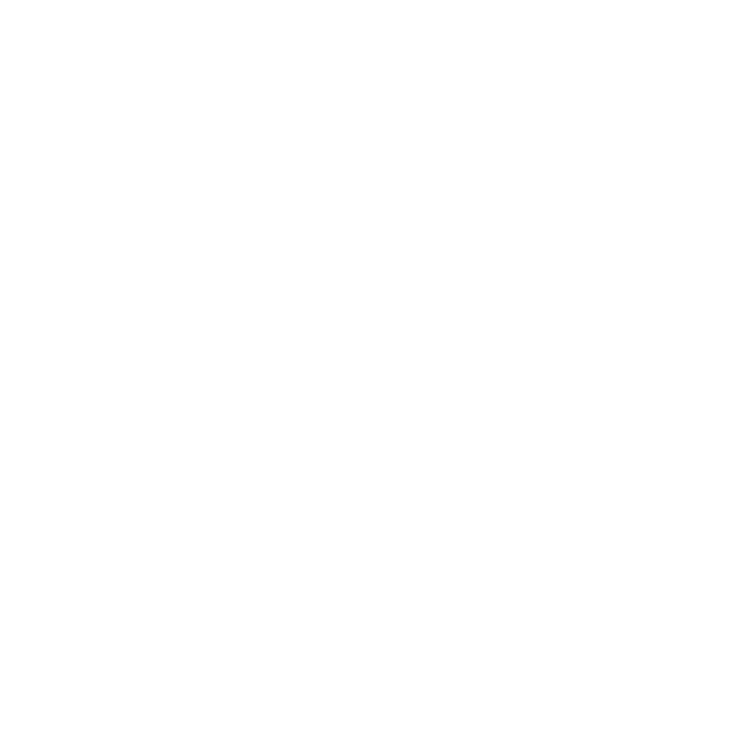

<IPython.core.display.Javascript object>


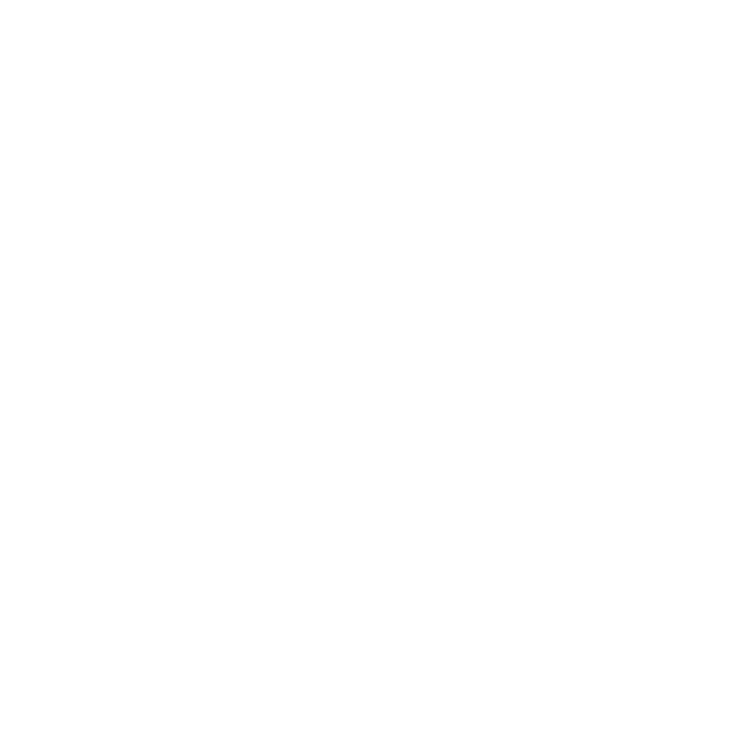

<IPython.core.display.Javascript object>


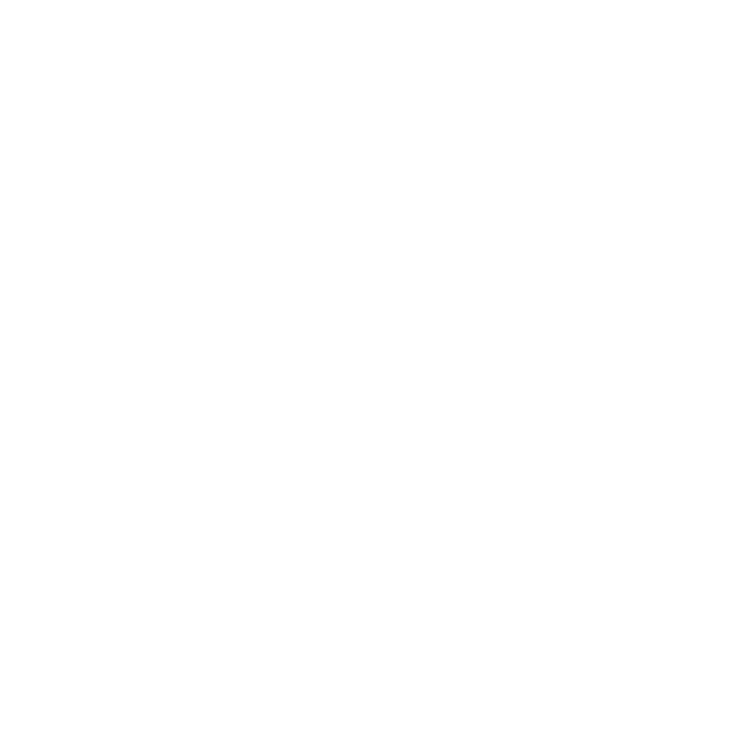

<IPython.core.display.Javascript object>


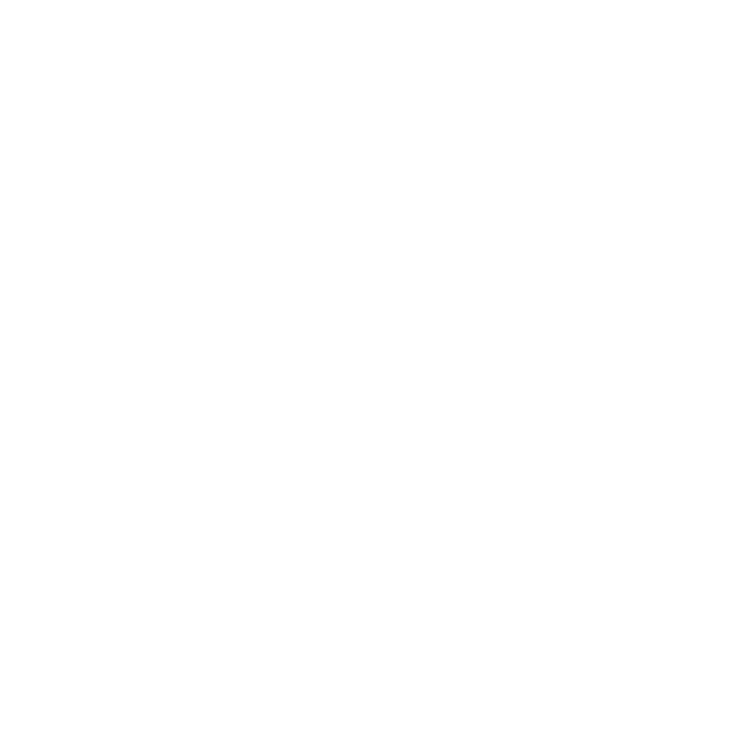

<IPython.core.display.Javascript object>


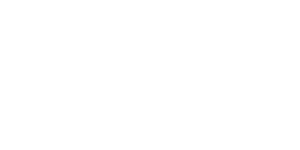

<IPython.core.display.Javascript object>


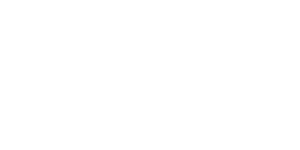

<IPython.core.display.Javascript object>


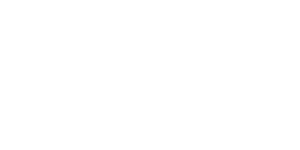

<IPython.core.display.Javascript object>


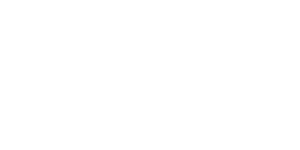

<IPython.core.display.Javascript object>


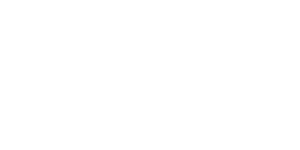

<IPython.core.display.Javascript object>


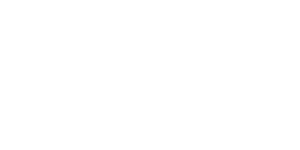

<IPython.core.display.Javascript object>


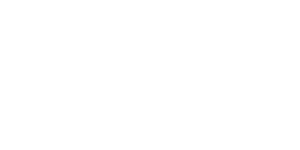

<IPython.core.display.Javascript object>


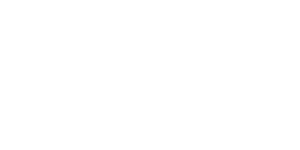

<IPython.core.display.Javascript object>


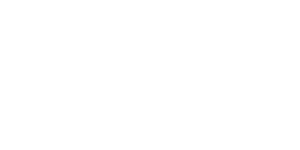

<IPython.core.display.Javascript object>


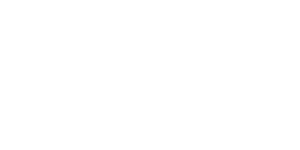

<IPython.core.display.Javascript object>


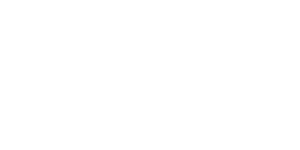

<IPython.core.display.Javascript object>


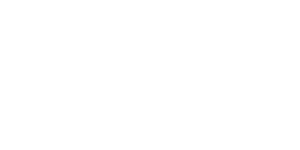

<IPython.core.display.Javascript object>


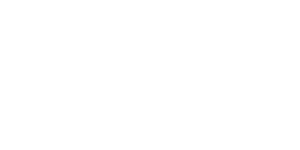

<IPython.core.display.Javascript object>


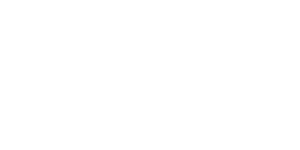

<IPython.core.display.Javascript object>


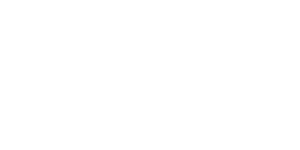

<IPython.core.display.Javascript object>


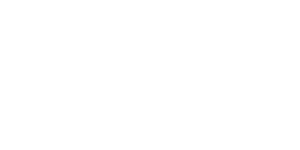

<IPython.core.display.Javascript object>


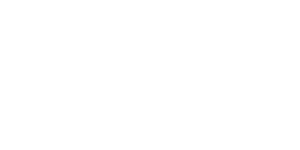

<IPython.core.display.Javascript object>


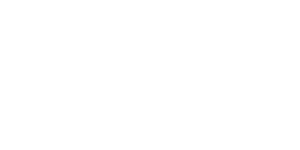

<IPython.core.display.Javascript object>


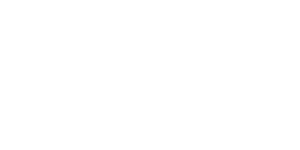

<IPython.core.display.Javascript object>


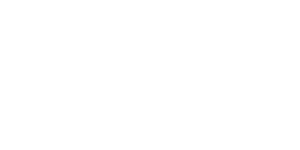

<IPython.core.display.Javascript object>


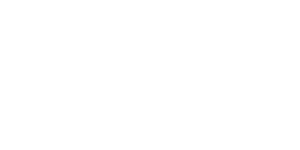

<IPython.core.display.Javascript object>


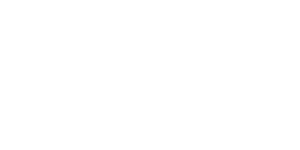

<IPython.core.display.Javascript object>


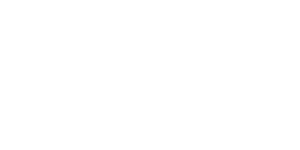

<IPython.core.display.Javascript object>


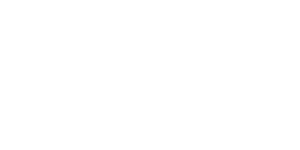

<IPython.core.display.Javascript object>


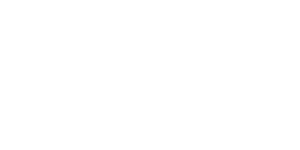

<IPython.core.display.Javascript object>


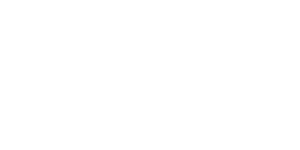

<IPython.core.display.Javascript object>


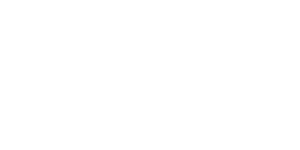

<IPython.core.display.Javascript object>


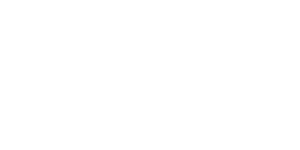

<IPython.core.display.Javascript object>


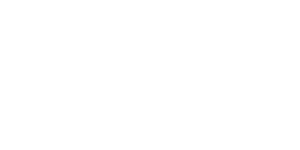

<IPython.core.display.Javascript object>


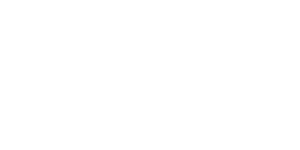

<IPython.core.display.Javascript object>


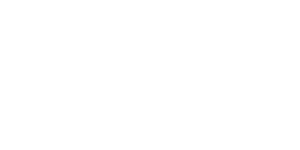

<IPython.core.display.Javascript object>


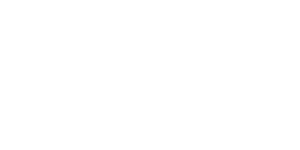

<IPython.core.display.Javascript object>


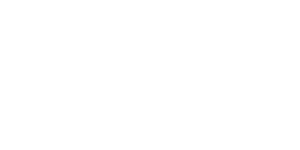

<IPython.core.display.Javascript object>


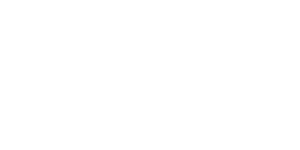

<IPython.core.display.Javascript object>


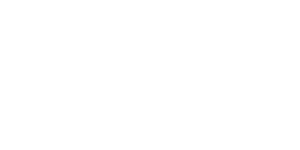

<IPython.core.display.Javascript object>


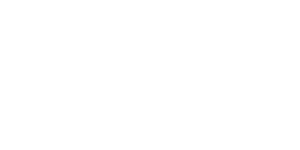

<IPython.core.display.Javascript object>


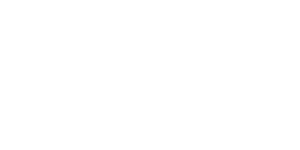

<IPython.core.display.Javascript object>


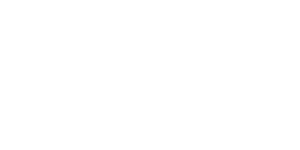

<IPython.core.display.Javascript object>


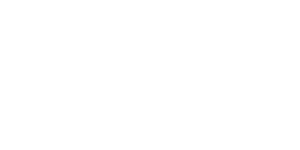

<IPython.core.display.Javascript object>


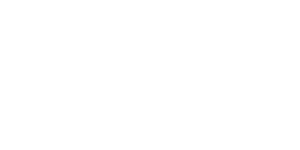

<IPython.core.display.Javascript object>


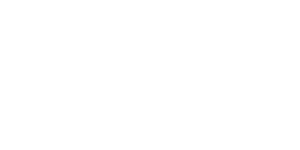

<IPython.core.display.Javascript object>


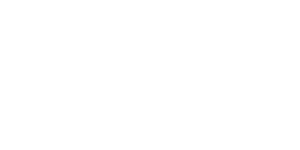

<IPython.core.display.Javascript object>


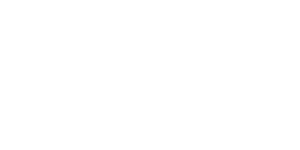

<IPython.core.display.Javascript object>


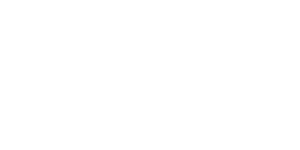

<IPython.core.display.Javascript object>


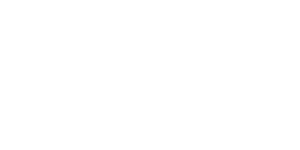

<IPython.core.display.Javascript object>


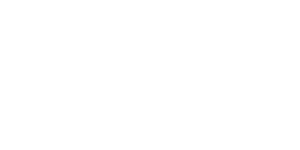

In [97]:
save_folder = "/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/103/"
for num in range(50):
    # num = 10

    fig = plt.figure(figsize=(10, 10), layout="constrained")
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[0, 1])

    # Plot the main image in ax1
    ax1.imshow(angs1_all[num][900:1200, 1000:1700], vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
    ax1.axhline(y=180, ls='--', c='b', alpha=0.8)

    # Plot a line in ax2
    tail_nr = min(num, 4)
    for i in range(tail_nr+1):
        ax2.plot(angs1_all[num-i][1080, 1300:1500], c='b', alpha=(0.5-0.1*i))
        ax2.set_ylim([-1, 1])
    # Define the inset region coordinates
    x_start, x_end = 500, 600
    y_start, y_end = 100, 200

    # Draw a rectangle in ax1 to indicate the inset region
    rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                         linewidth=1, edgecolor='white', facecolor='none', linestyle='--')
    ax1.add_patch(rect)

    # Plot the inset region in ax3
    inset_region = angs1_all[num][900 + y_start:900 + y_end, 1000 + x_start:1000 + x_end]
    ax3.imshow(inset_region, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')

    # Add titles or labels if necessary
    ax1.set_title("Main Image with Inset")
    ax2.set_title("Line Plot")
    ax3.set_title("Inset Zoomed Region")

    # Connect the rectangle in ax1 to ax3 using annotation lines
    ax1_coords = [(x_start, y_start), (x_end, y_start), (x_end, y_end), (x_start, y_end)]
    ax3_coords = [(0, 0), (1, 0), (1, 1), (0, 1)]  # Corners of ax3 (in normalized axes coordinates)

    plt.savefig(save_folder + str(num).zfill(3) + ".png")
    plt.close()

In [528]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_average_spectrum(image_list):
    spectra = []
    for image in image_list:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        spectra.append(20 * np.log(np.abs(fshift)))
    
    avg_spectrum = np.mean(spectra, axis=0)
    return avg_spectrum

def remove_noise_using_adaptive_mask(image, avg_spectrum, threshold=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    
    # Create a mask based on the average spectrum
    magnitude = 20 * np.log(np.abs(fshift))
    mask = magnitude < (avg_spectrum + threshold)  # Keep frequencies below the threshold
    
    # Apply the mask
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    return img_back

# Load multiple noisy images
images = [angs1_all[i][900:1200, 1000:1700] for i in range(30, 50)]
# Compute average spectrum and apply adaptive masking
avg_spectrum = compute_average_spectrum(images)
denoised_image = remove_noise_using_adaptive_mask(images[0], avg_spectrum)

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(images[0], vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
ax[1].imshow(denoised_image, vmin=-1, vmax=1, cmap='afmhot_r', aspect='auto')

plt.show()


<IPython.core.display.Javascript object>

# SIMULATIONS 

## Simulating Condensate

#### Functions

In [3]:
# Initial values
offset = 0.0
amp_ov = 1.0
ang = 0
centerx = 150
centery = 350
tfa = 1
tfwx = 10
tfwy = 50
ga = 1
gwx = 30
gwy = 80
params = np.array([offset, amp_ov, ang, centerx, centery, tfa, tfwx, tfwy, ga, gwx, gwy])

def createSampleImage(shape=(300, 700), params_dict=None, rand=False, norm_dens=True):
    """
    Generate a synthetic image of a Bose-Einstein condensate cloud.
    
    Parameters:
        shape (tuple): Shape of the output image (height, width).
        params_dict (dict): Parameters dictionary from `generate_cloud` or `evaporative_cooling_simulation`.
        rand (bool): Whether to generate random parameters.
        norm_dens (bool): whether to return normalized density to 1, or actual density. 
    Returns:
        np.array: A synthetic image of the BEC cloud.
    """
    if rand:
        # Generate random parameters for a BEC cloud
        offset = random.random() * 0.05
        amp_ov = random.random()
        ang = random.choice([-1, 1]) * random.random() * 0.02
        centerx = random.randint(100, 200)
        centery = random.randint(300, 400)
        tfa = random.random()  # Random condensation fraction
        tfwx = random.randint(5, 10)
        tfwy = random.randint(50, 100)
        ga = 1 - tfa  # Thermal cloud amplitude
        gwx = tfwx + random.randint(0, 20)
        gwy = tfwy + random.randint(0, 40)

        params = np.array([offset, amp_ov, ang, centerx, centery, tfa, tfwx, tfwy, ga, gwx, gwy])

    elif params_dict is not None:
        # Extract parameters from the provided dictionary
        offset = 0.0  # No background offset in the simulation output
#         if norm_dens:
        amp_ov = 1  # Overall amplitude (arbitrary scaling factor)
#         else:
#             amp_ov = params_dict["n0"]  # If central density
        ang = 0.0  # No tilt in the cloud
        centerx = params_dict.get("centerx", shape[0] // 2)
        centery = params_dict.get("centery", shape[1] // 2)
        tfa = max(params_dict["n0"], 1e-6) #max(params_dict["cond_fraction"], 1e-6)  # Condensation fraction
        tfwx = max(params_dict["R_r"], 1e-6)  # Thomas-Fermi radius in x-direction (already in pixels)
        tfwy = max(params_dict["R_z"], 1e-6)  # Thomas-Fermi radius in y-direction (already in pixels)
        ga = max(params_dict["n0_th"], 1e-6) # 1 - tfa  # Gaussian amplitude (thermal cloud)
        gwx = params_dict["sigma_r"]  # Gaussian width in x-direction (already in pixels)
        gwy = params_dict["sigma_z"]  # Gaussian width in y-direction (already in pixels)

        params = np.array([offset, amp_ov, ang, centerx, centery, tfa, tfwx, tfwy, ga, gwx, gwy])
    else:
        # Default parameters if neither rand nor params_dict is provided
        params = np.array([0.0, 1.0, 0.0, 150, 350, 1, 10, 50, 1, 30, 80])

    # Generate mesh grid for image
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    xv, yv = np.meshgrid(x, y, indexing='ij')
    fitvars = np.array([xv, yv]).reshape(2, -1)

    # Create the synthetic image using bimodalmod_OAH
    image_synth = bimodalmod_OAH(params, fitvars).reshape(shape[0], shape[1])
    return image_synth

def generate_cloud(T, N, omega_r=110*2*np.pi, omega_z=15*2*np.pi):
    """
    Generate a cloud of a Bose-Einstein condensate at given temperature, chemical potential, and particle number.
    
    Parameters:
        T (float): Temperature in Kelvin.
        N (int): Total particle number.
        omega_r (float): Radial trapping frequency in rad/s. Default is 110 * 2 * pi.
        omega_z (float): Axial trapping frequency in rad/s. Default is 15 * 2 * pi.
    
    Returns:
        dict: A dictionary containing the parameters of the generated cloud.
    """
    # Constants:
    k_B = 1.38064852E-23
    m_na = 3.81923979E-26
    hbar = 1.0545718E-34
    a_s = 2.802642E-9
    pix_size = 6.5E-6 / 2.63

    # Compute critical temperature
    T_c = (hbar * omega_r / k_B) * (N / 1.202)**(1/3)

    # Condensation fraction
    cond_fraction = max(0, 1 - (T / T_c)**3)
    N0 = cond_fraction * N

    # Update chemical potential using the Thomas-Fermi approximation
    mu = ((15 * hbar**2 * m_na**(1/2) * N0 * a_s * omega_r**2 * omega_z) / 2**(5/2))**(2/5)

    # Thomas-Fermi radii
    R_r = np.sqrt(2 * mu / (m_na * omega_r**2))
    R_z = np.sqrt(2 * mu / (m_na * omega_z**2))

    # Peak density
    g = 4 * np.pi * hbar**2 * a_s / m_na
    n0 = mu / g
    n_col_0 = (8 / 15) * n0 * R_z


    # Thermal cloud width
    sigma_r = np.sqrt(k_B * T / (m_na * omega_r**2))
    sigma_z = np.sqrt(k_B * T / (m_na * omega_z**2))
    
    # Thermal particle number
    N_thermal = N * (1 - cond_fraction)

    # Central density of the thermal cloud
    n_col_thermal_0 = N_thermal / (2 * np.pi * sigma_r**2)
    
    # Return the parameters of the generated cloud
    return {
        "T": T,
        "N": N,
        "N0": N0,
        "cond_fraction": cond_fraction,
        "mu": mu,
        "R_r": R_r / pix_size,
        "R_z": R_z / pix_size,
        "n0": n_col_0,
        "n0_th": n_col_thermal_0,
        "sigma_r": sigma_r / pix_size,
        "sigma_z": sigma_z / pix_size,
        "T_c": T_c
    }


def evaporative_cooling_simulation(T_init, mu_init, N_init, target_T, omega_r=110*2*np.pi, omega_z=15*2*np.pi, cooling_steps=50):
    """
    Simulate evaporative cooling in a harmonic trap for a Bose-Einstein condensate.

    Parameters:
        T_init (float): Initial temperature in Kelvin.
        mu_init (float): Initial chemical potential in Joules.
        N_init (int): Initial total particle number.
        target_T (float): Target temperature in Kelvin.
        omega_r (float): Radial trapping frequency in rad/s.
        omega_z (float): Axial trapping frequency in rad/s.
        cooling_steps (int): Number of steps in the simulation.

    Returns:
        list: A list of dictionaries containing parameters at each step.
    """
    # Initialize variables
    T = T_init
    mu = mu_init
    N = N_init
    results = []
    
    # This will ensure that we exponentially lower the temperature, and still reach the desired 
    # final T in the number or steps. Alpha is determined by the cooling efficiency parameter 
    # (see e.g. eq. 2.3 in Bons)
    eta = 17
    alpha = (1 / 3) * (eta - 2)  # Compute alpha based on given eta
    cooling_factor = (target_T / T_init) ** (1 / (alpha * cooling_steps))
    
    for step in range(cooling_steps):
        # Generate cloud at current T, mu, and N
        cloud = generate_cloud(T, N, omega_r, omega_z)
        cloud["step"] = step  # Add step information
        results.append(cloud)
        
#         T -= (T_init - target_T) / cooling_steps
        T *= (cooling_factor ** alpha) 
        N *= cooling_factor
        # Stop if temperature reaches target
        if T <= target_T:
            break

    return results


### Density plot as a function of temperature and particle number

0.7627630607645856
0.9019350365783644


<IPython.core.display.Javascript object>


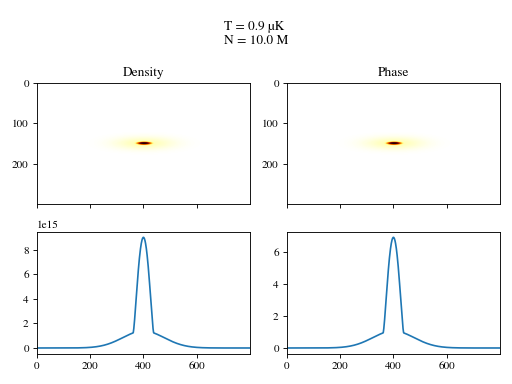

In [380]:
cloud_params = generate_cloud(9e-7, 10e6, omega_r=110*2*np.pi, omega_z=15*2*np.pi)
image_synth = createSampleImage(shape=(300, 800), params_dict=cloud_params, rand=False, norm_dens=False)

print(cloud_params['n0']/1e16)
print(image_synth.max()/1e16)

temp_uK = round(cloud_params['T'] * 1e6, 2)  # Convert temperature to microkelvin
N_million = round(cloud_params['N'] / 1e6, 2)  # Convert particle number to millions

fig, ax = plt.subplots(2, 2, sharex=True)
fig.suptitle(f"\nT = {temp_uK} µK \nN = {N_million} M")
ax[0][0].set_title("Density")
ax[0][0].imshow(image_synth, cmap="afmhot_r", aspect='auto')
ax[1][0].plot(image_synth[150])

image_synth = image_synth * pf
ax[0][1].set_title("Phase")
ax[0][1].imshow(image_synth, cmap="afmhot_r", aspect='auto')
ax[1][1].plot(image_synth[150])

plt.tight_layout()
plt.show()

### Simulating Evaporative Cooling

#### Loop And Save 

In [573]:
# Run evaporative cooling simulation
cooling_results = evaporative_cooling_simulation(T_init=1e-6, mu_init=1e-30, N_init=10e6, target_T=1e-7)

# Loop through each step of the cooling simulation
for r, result in enumerate(cooling_results):
    # Generate synthetic image using parameters from cooling simulation
    image_synth = createSampleImage(shape=(300, 700), params_dict=result)
    temp_uK = round(result['T'] * 1e6, 2)  # Convert temperature to microkelvin
    N_million = round(result['N'] / 1e6, 2)  # Convert particle number to millions

    # Plot and save the synthetic image
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].imshow(image_synth, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
    ax[1].plot(image_synth[150], alpha=0.7)
    fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M")
    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/synthetic_cooling/{str(r).zfill(3)}.png")

    plt.close()
    clear_output()


#### Slider

In [689]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

shape = (200, 700)
noise = True
# Assuming these functions return the necessary data
# evaporative_cooling_simulation should return a list of dictionaries with T and N values
cooling_results = evaporative_cooling_simulation(T_init=2e-6, mu_init=1e-30, N_init=30e6, target_T=1e-7)

# Initial plot setup
initial_params = cooling_results[0]
image_synth = createSampleImage(shape=(300, 700), params_dict=initial_params)
temp_uK = round(initial_params['T'] * 1e6, 2)  # Convert temperature to microkelvin
N_million = round(initial_params['N'] / 1e6, 2)  # Convert particle number to millions
con_frac = initial_params['cond_fraction']  # Convert particle number to millions

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
im = ax[0].imshow(image_synth, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
line, = ax[1].plot(image_synth[150], alpha=0.7)
fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M @ {con_frac*100} %")
ax[1].set_ylim([-0.2, 1.2])

# Update function for interact
def update(i):
    params = cooling_results[i]
    image_synth = createSampleImage(shape=shape, params_dict=params) 
    if noise: 
        image_synth += np.random.normal(np.mean(image_synth), 0.1, image_synth.shape)
    temp_uK = round(params['T'] * 1e6, 2)  # Convert temperature to microkelvin
    N_million = round(params['N'] / 1e6, 2)  # Convert particle number to millions
    con_frac = round(params['cond_fraction'], 2)  # Convert particle number to millions

    im.set_data(image_synth)
    line.set_ydata(image_synth[shape[0]//2])  # Update line plot
    fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M @ {con_frac*100} %")
    fig.canvas.draw_idle()

# Create interactive slider
interact(update, i=IntSlider(min=0, max=len(cooling_results)-1, step=1, value=0));


<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<IPython.core.display.Javascript object>


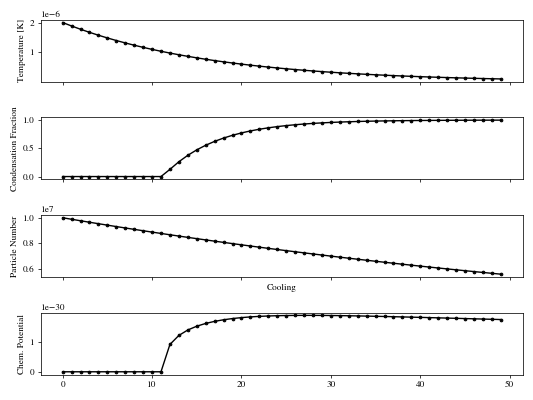

In [30]:
temperatures = [res['T'] for res in cooling_results]
cond_fractions = [res['cond_fraction'] for res in cooling_results]
part_num = [res['N'] for res in cooling_results]
chem_pot = [res['mu'] for res in cooling_results]

fig, ax = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax[0].plot(temperatures, marker='.', c='k')
ax[1].plot(cond_fractions, marker='.', c='k')
ax[2].plot(part_num, marker='.', c='k')
ax[3].plot(chem_pot, marker='.', c='k')

ax[2].set_xlabel('Cooling')

ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Condensation Fraction')
ax[2].set_ylabel('Particle Number')
ax[3].set_ylabel('Chem. Potential')

plt.tight_layout()
plt.show()


#### Extended Slider 

<IPython.core.display.Javascript object>


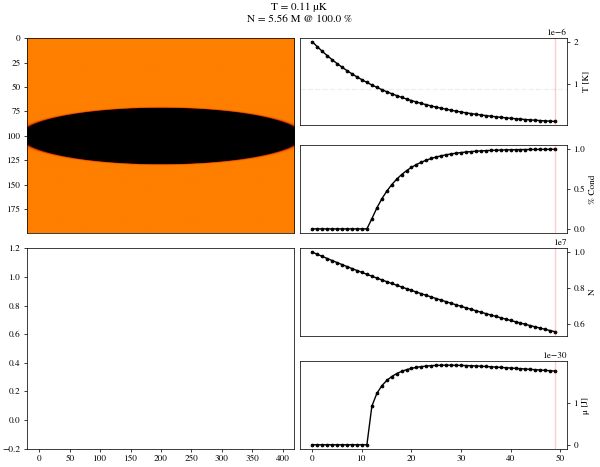

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [29]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

shape = (200, 400)

# Assuming these functions return the necessary data
# evaporative_cooling_simulation should return a list of dictionaries with T and N values
cooling_results = evaporative_cooling_simulation(T_init=2e-6, mu_init=1e-30, N_init=10e6, target_T=1e-7)
image_synth_all = [createSampleImage(shape=shape, params_dict=params) for params in cooling_results]

# Initial plot setup
initial_params = cooling_results[0]
image_synth = image_synth_all[0]
temp_uK = round(initial_params['T'] * 1e6, 2)  # Convert temperature to microkelvin
temp_uK_crit = initial_params['T_c']   # Critical temperature
N_million = round(initial_params['N'] / 1e6, 2)  # Convert particle number to millions
con_frac = initial_params['cond_fraction']  # Convert particle number to millions

fig = plt.figure(figsize=(9, 7), layout="constrained")
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:4, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, 1])

im = ax1.imshow(image_synth, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
line, = ax2.plot(image_synth[150], alpha=0.7)
fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M @ {con_frac*100} %")
ax2.set_ylim([-0.2, 1.2])

temperatures = [res['T'] for res in cooling_results]
cond_fractions = [res['cond_fraction'] for res in cooling_results]
part_num = [res['N'] for res in cooling_results]
chem_pot = [res['mu'] for res in cooling_results]

ax3.plot(temperatures, marker='.', c='k')
ax4.plot(cond_fractions, marker='.', c='k')
ax5.plot(part_num, marker='.', c='k')
ax6.plot(chem_pot, marker='.', c='k')

l7 = ax3.axhline(y=temp_uK_crit, ls ='--', alpha=0.1)
# ax3.text('$T_C$', 50, temp_uK_crit)

l3 = ax3.axvline(x=0, alpha=0.2, c='r')
l4 = ax4.axvline(x=0, alpha=0.2, c='r')
l5 = ax5.axvline(x=0, alpha=0.2, c='r')
l6 = ax6.axvline(x=0, alpha=0.2, c='r')

ax3.set_ylabel('T [K]')
ax4.set_ylabel('% Cond') 
ax5.set_ylabel('N')
ax6.set_ylabel(u'\u03BC [J]')

for ax in [ax3, ax4, ax5, ax6]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
for ax in [ax3, ax4, ax5, ax1]:
    ax.set_xticks([])


# Update function for interact
def update(i):
    params = cooling_results[i]
    image_synth = image_synth_all[i]
    temp_uK = round(params['T'] * 1e6, 2)  # Convert temperature to microkelvin
    temp_uK_crit = params['T_c']   # Critical temperature
    N_million = round(params['N'] / 1e6, 2)  # Convert particle number to millions
    con_frac = round(params['cond_fraction'], 2)  # Convert particle number to millions

    im.set_data(image_synth)
    line.set_ydata(image_synth[shape[0]//2])  # Update line plot
    fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M @ {con_frac*100} %")
    fig.canvas.draw_idle()

    l3.set_xdata(i)
    l4.set_xdata(i)
    l5.set_xdata(i)
    l6.set_xdata(i)
    l7.set_ydata(temp_uK_crit)
    
# Create interactive slider
interact(update, i=IntSlider(min=0, max=len(cooling_results)-1, step=1, value=0));


### Add Interference and Reconstruction of the Phase

##### Functions

In [4]:
detuning=36
wavelength=589e-9
sigma_0 = 3 * wavelength**2 / (2 * np.pi)
prefactor = 2/3* (sigma_0 * detuning) / (1+4*detuning**2) 

def makeInterference(size, angle1=200, angle2=240, 
                     condensate=0, T=1e-6, N=10e6,
                     curvature_probe=0.001, curvature1=0.001, curvature2=0.001, 
                     windowalpha=0.01, windowtype="tukey", 
                     ref_crosstalk=False):
    """ 
    Create an interference pattern of a probe and two reference beams with curved wavefronts.
    angle1: Angle of the first reference beam, in degrees?
    angle2: Angle of the second reference beam.
    condensate: 0 or 1 - Whether to include a condensate-like phase object.
    T: Temperature of the cloud
    N: Particle number in the cloud
    curvature_probe: Curvature parameter for the probe beam.
    curvature1: Curvature parameter for the first reference beam.
    curvature2: Curvature parameter for the second reference beam.
    """
    # Physical parameters
    wavelength = 589e-9  # Wavelength in meters (589 nm)
    pixel_size = 2.47148288973384e-6  # Pixel size in meters
    
    # Create grid for image in physical units
    x = np.linspace(-size[0] / 2, size[0] / 2, size[0]) * pixel_size
    y = np.linspace(-size[1] / 2, size[1] / 2, size[1]) * pixel_size
    Xgrid, Ygrid = np.meshgrid(y, x)
    
    # Create a condensate-like phase object
    cloud_params = generate_cloud(T, N)
    image_synth = createSampleImage(shape=size, params_dict=cloud_params, rand=False, norm_dens=False)
#     detuning = 35
#     prefactor = float(((3 * (wavelength ** 2)) * detuning) / (1 + 4 * detuning ** 2) * 2 * np.pi)
    phase = prefactor * image_synth
    True_phase = np.exp(1.0j * condensate * phase)
    
    # Convert angles to radians and compute wave vectors
    angle1_rad = np.radians(angle1)
    angle2_rad = np.radians(angle2)
    
    k1 = (2 * np.pi / wavelength) * np.array([np.cos(angle1_rad), np.sin(angle1_rad)])
    k2 = (2 * np.pi / wavelength) * np.array([np.cos(angle2_rad), np.sin(angle2_rad)])
    
    # Create the probe beam with curvature
    probe_beam = np.exp(1.0j * curvature_probe * (Xgrid**2 + Ygrid**2))
    
    # Create reference fields with curvature terms
    ref1 = np.exp(1.0j * (k1[0] * Xgrid + k1[1] * Ygrid)) * np.exp(1.0j * curvature1 * (Xgrid**2 + Ygrid**2))
    ref2 = np.exp(1.0j * (k2[0] * Xgrid + k2[1] * Ygrid)) * np.exp(1.0j * curvature2 * (Xgrid**2 + Ygrid**2))
    
    # Generate interference patterns with the probe beam   
    if ref_crosstalk:
        InterferencePatternTotal = np.real((True_phase * probe_beam  + ref1 + ref2) * (True_phase * probe_beam  + ref1 + ref2).conj())
    else:
        InterferencePattern1 = np.real(True_phase * probe_beam * ref1) + 0.5
        InterferencePattern2 = np.real(True_phase * probe_beam * ref2) + 0.5
        InterferencePatternTotal = InterferencePattern1 + InterferencePattern2

    # Apply a window function for smoother edges in Fourier space
    window = 1
    if windowtype == "tukey":
        window = tukey(size[0], alpha=windowalpha, sym=True)[:, np.newaxis] * tukey(size[1], alpha=windowalpha, sym=True)[np.newaxis, :]
    
    elif windowtype == "oval":
        window = oval_window(size, alpha=windowalpha, aspect_ratio=1.5)

    elif windowtype == "triangle":
        window = triangular_window(size)

    elif windowtype == "circle":
        window = circular_window(size, radius=0.5)

    elif windowtype == "house":
        window = house_window(size, width_ratio=windowalpha, roof_height_ratio=0.3)
    
    elif windowtype == "none":
        window = 1
        
    Fourier_space = np.fft.fftshift(np.fft.fft2(InterferencePatternTotal * window))

    return InterferencePatternTotal * window, Fourier_space


def HI_refocus_synthetic(atoms, flat, dz_focus, quad="quad1", x=None, z=None, indices=None, edge_x=10, edge_z=80, MTF=False):
    """
    Main function for generating the output arrays for the holgoraphic imaging, which also includes the refocusing.
    What we do, is we process image - first take a FTT, apply Tukey windows, shift, refocus, and back iFFT.
    ------
    :param date: Input date of the image to be analysed
    :param shot: Input shot of the image to be analysed
    :param num: Input sequence number of the image to be analysed
    :param dz_focus: The focus parameter that determines the focus of the image
    :param quad: Parameter to determine which quad we are cutting.
    :param plot: Boolean to specify whether to plot the image of the angle or not. Better not when used in a loop.
    :return: Returns an array of the angle of the ratio of the iFFT's of the atom and flat image.
    """
    # ----------------------------------------------- CORRECTIONS ---------------------------------------------------
    # Creates a squaroid dark edge
    atoms = f1.squaroid(atoms, width=0.51)
    flat = f1.squaroid(flat, width=0.51)

    # --------------------------------------------------- FFT --------------------------------------------------------
    # Take the FTT of the atoms
    fft_atoms = np.fft.fft2(atoms)
    fft_flat = np.fft.fft2(flat)
    

    P_k = np.ones(fft_atoms.shape)
    if MTF:
        # Define the pixel width
        pixelsize =  6.5E-6
        fft_kx = np.fft.fftfreq(fft_atoms.shape[0], d=pixelsize)  # Discrete FFT Sample Frequency in x
        fft_ky = np.fft.fftfreq(fft_atoms.shape[1], d=pixelsize)
        # Compute the Fourier Transform of the pixel
        P_k = np.sinc(fft_kx * pixelsize * 2)[:, None] * np.sinc(fft_ky * pixelsize * 2)[None, :]
        fft_atoms /= P_k
        fft_flat /= P_k

    # We create the Tukey windows cutouts for the data and the background. Additional cuts in x,z direction can be
    # passed, but this is optional; the default value is 0. Note that because you later cut everything in the
    # same size, this may affect the rest too.
    quad1, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, x=x, z=z)
    flatq1, f1peak = f1.box_cutter_pad_ellips(fft_flat, quad, x=x, z=z)
    
    # Cutting the quads in the same sizes.
    quad1cut, flatq1cut = f1.sizecomp(quad1, flatq1)

    # ------------------------------------------------ FFT SHIFT ----------------------------------------------------
    # Now we FFT shift the zero frequency to the center
    fft1 = np.fft.fftshift(quad1cut)
    flatfft1 = np.fft.fftshift(flatq1cut)

    # ------------------------------------------------ REFOCUSING ---------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied
    ly = 0  # .5E6#-3E6#.                                           # Adjusting the fft_ky array
    coma_y_arg = ly * fft_ky[:, None] * (3 * fft_k2 / k0 ** 2) / k0
    lin_y = np.exp(-1j * coma_y_arg)

#     if MTF:
#         # Define gradient magnitudes in x and y directions (adjust as needed)
#         gradient_x=0.0001
#         gradient_z=0.0001
#         linear_gradient_x = np.exp(-1j * gradient_x * fft_kx[None, :])  # Linear gradient in x
#         linear_gradient_z = np.exp(-1j * gradient_z * fft_ky[:, None])  # Linear gradient in y
#         linear_gradient_correction = linear_gradient_x * linear_gradient_z
#         fft1 *= linear_gradient_correction
#         flatfft1 *= linear_gradient_correction
        
    # Determine the focus factor and refocus
    focus = np.exp(-1j * fft_k2 * dz_focus / (2 * k0))
    fft1 = fft1 * focus * lin_y
    flatfft1 = flatfft1 * focus * lin_y

    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)
    

    inv1 = inv1 #[border_x:-border_x, border_z:-border_z]

    # Get Phase
    ang1 = np.angle(inv1)
    ang1 = f1.unwrapper(ang1)

    # Normalize
    normfactor = ang1.mean()  # [300:900, 300:900].mean()
    ang1 = ang1 - normfactor
    ang1 = normalize(ang1)[0] # Use the function above to normalize the image.
    
    return ang1



def previewReconstruction(cloud_params, size=(500, 500), noise=True, noise_par=0.5):
    image_synth = createSampleImage(shape=size, params_dict=cloud_params, rand=False, norm_dens=False)
    image_synth = prefactor * image_synth
    
    T = cloud_params['T']  # Convert temperature to microkelvin
    N = cloud_params['N']  # Convert particle number to millions

    # Generate Interference Pattern
    atoms, FS_a = makeInterference(size=size, angle1=3, angle2=-3, condensate=1, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=10, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)
    flat, FS_f  = makeInterference(size=size, angle1=3, angle2=-3, condensate=0, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=10, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)

    if noise: 
        ## add noise 
        atoms = atoms * np.random.normal(np.mean(atoms), noise_par, atoms.shape)
        flat = flat * np.random.normal(np.mean(flat), noise_par, flat.shape)

    # Process The Interference Pattern
    ang1 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1")
    ang2 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad3")
    

    # Cut the images
    cut_edgex = 200 # size[0]//2 - 50
    cut_edgey = 200 # size[1]//2 - 50
    gt = image_synth[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
    rec1 = ang1[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
    rec2 = ang2[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]

    # Create figure and gridspec layout
    fig = plt.figure(figsize=(15, 9))
    gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1], hspace=0.4, wspace=0.3)

    # Top row: images
    ax_img_gt = fig.add_subplot(gs[0, 0:2])
    ax_img_rec1 = fig.add_subplot(gs[0, 2:4])
    ax_img_rec2 = fig.add_subplot(gs[0, 4:6])

    # Bottom row: combined plots
    ax_linecuts = fig.add_subplot(gs[1, 0:3])  # Spanning two columns
    ax_transposed = fig.add_subplot(gs[1, 3:6])  # Single column for transposed cuts

    # Plot images
    im = ax_img_gt.imshow(gt, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
    ax_img_rec1.imshow(rec1, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
    ax_img_rec2.imshow(rec2, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')

    # Titles for images
    ax_img_gt.set_xlabel("Ground truth", fontsize=12)
    ax_img_rec1.set_xlabel("Reconstructed OAH-1", fontsize=12)
    ax_img_rec2.set_xlabel("Reconstructed OAH-2", fontsize=12)

    # Remove ticks from image axes
    for ax in [ax_img_gt, ax_img_rec1, ax_img_rec2]:
        ax.set_xticks([])
        ax.set_yticks([])

    # Plot all line cuts (horizontal) on one subplot
    ax_linecuts.plot(gt[cut_edgex], label="Ground truth", color="C0", alpha=0.6)
    ax_linecuts.plot(rec1[cut_edgex], label="OAH-1", color="C1", alpha=0.6)
    ax_linecuts.plot(rec2[cut_edgex], label="OAH-2", color="C2", alpha=0.6)
    ax_linecuts.set_title("Horizontal line cuts")
    ax_linecuts.legend()

    # Plot all transposed line cuts (vertical) on another subplot
    ax_transposed.plot(gt.T[cut_edgey], label="Ground truth", color="C0", alpha=0.6)
    ax_transposed.plot(rec1.T[cut_edgey], label="OAH-1", color="C1", alpha=0.6)
    ax_transposed.plot(rec2.T[cut_edgey], label="OAH-2", color="C2", alpha=0.6)
    ax_transposed.set_title("Vertical line cuts")
    ax_transposed.legend()

    # Overall title
    ax_transposed.set_ylim([0-gt.max()*0.2, gt.max()*1.2])
    ax_linecuts.set_ylim([0-gt.max()*0.2, gt.max()*1.2])

    cbar = plt.colorbar(im, ax=[ax_img_gt, ax_img_rec1, ax_img_rec2, ax_linecuts, ax_transposed], aspect=40)
    cbar.set_label("$\phi$ [rad]", rotation=90, fontsize=12)

    fig.suptitle(f"-- PHASE RECONSTRUCTION -- \nT = {round(T * 1e6, 2)} uK, N = {round(N / 1e6, 2)} M \nNoise = {noise_par} \n", fontsize=16)
    plt.show()

#### Let's see

In [4]:
T = 2e-6
N = 10e6
size = (1000, 1000)
noise = True
noise_par = 0.05

cloud_params = generate_cloud(T, N)
previewReconstruction(cloud_params, size, noise=noise, noise_par=noise_par)

Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
(1000, 1000) (1000, 1000)
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
(1000, 1000) (1000, 1000)


<IPython.core.display.Javascript object>

#### This but through cooling

In [107]:
# Generate Ground Truth
T = 10e-7
N = 10e6
size = (1000, 1000)
noise = True
noise_par = 0.05

cooling_results = evaporative_cooling_simulation(T_init=4e-6, mu_init=1e-30, N_init=10e6, target_T=1e-7, cooling_steps=100)

for r, result in enumerate(cooling_results):
    previewReconstruction(result, size, noise=noise, noise_par=noise_par)
    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/synthetic_cooling_with_OAH/{str(r).zfill(3)}.png")
    plt.close()
    clear_output()

#### Displacement - With and Without Noise 

In [50]:
# Variables
T = 10e-7
N = 12e6
size = (1000, 1000)
noise = True
noise_par = 0.25
# x = 100
x = 0
z = 0

fit1_params = [[ ], 
               [ ] ]

fit2_params = [[ ], 
               [ ] ]



# noise_noise = np.random.normal(np.mean(atoms), noise_par, atoms.shape)
cooling_results = evaporative_cooling_simulation(T_init=3e-6, mu_init=1e-30, N_init=10e6, target_T=1e-6, cooling_steps=10)

for r, result in enumerate(cooling_results):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(5, 6, height_ratios=[2, 1, 1, 1, 1])  # First row has double the height
    ax_fft_1 = fig.add_subplot(gs[0, 0:3])  # First row spans all columns
    ax_fft_2 = fig.add_subplot(gs[0, 3:6])
    ax1_no_noise = fig.add_subplot(gs[1, 0:2])
    ax2_no_noise = fig.add_subplot(gs[1, 2:4])
    ax3_no_noise = fig.add_subplot(gs[1, 4:6])
    ax1_noise = fig.add_subplot(gs[2, 0:2])
    ax2_noise = fig.add_subplot(gs[2, 2:4])
    ax3_noise = fig.add_subplot(gs[2, 4:6])
    ax_fit_1 = fig.add_subplot(gs[3, 2:4])
    ax_fit_2 = fig.add_subplot(gs[3, 4:6])    
    ax_fit_1_noise = fig.add_subplot(gs[4, 2:4])
    ax_fit_2_noise = fig.add_subplot(gs[4, 4:6])
    ax_linecuts = fig.add_subplot(gs[3:5, 0:2])

    axs_0 = [ax_fft_1, ax_fft_2]
    ax_img_gt = [ax1_no_noise, ax1_noise]
    ax_img_rec1 = [ax2_no_noise, ax2_noise]
    ax_img_rec2 = [ax3_no_noise, ax3_noise]
    ax_fits1 = [ax_fit_1, ax_fit_1_noise]
    ax_fits2 = [ax_fit_2, ax_fit_2_noise]

    
    T = result['T']  
    N = result['N']

    # Generate the phase information of the cloud 
#     cloud_params = generate_cloud(T, N)
    image_synth = createSampleImage(shape=size, params_dict=result, rand=False, norm_dens=False) * prefactor

    for i in [0, 1]:
        # Generate FFT Image 
        atoms, FS_a = makeInterference(size=size, angle1=3, angle2=-3, condensate=1, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=10, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)
        flat, FS_f  = makeInterference(size=size, angle1=3, angle2=-3, condensate=0, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=10, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)

        if i: 
    #     if noise: 
            ## add noise 
            atoms = atoms * np.random.normal(np.mean(atoms), noise_par, atoms.shape)
            flat = flat * np.random.normal(np.mean(flat), noise_par, flat.shape)

        fft_atoms = np.fft.fft2(f1.squaroid(atoms, width=0.51))
        axs_0[i].imshow(abs(fft_atoms), vmin=0, vmax=1e4)
        for quad, c in zip(["quad1", "quad2"], ['r', 'g']):
            quad1, q1peak = f1.box_cutter_pad_ellips(fft_atoms, quad, x=x, z=z)
            axs_0[i].scatter([q1peak[1]], [q1peak[0]], c=c, marker='x')
            height, width = find_ellipse_dimensions(abs(quad1))
            e1 = patches.Ellipse((q1peak[1], q1peak[0]), width, height, angle=0, linewidth=2, color=c, fill=False, zorder=2)
            axs_0[i].add_patch(e1)

        axs_0[i].axvline(size[0]//2)
        axs_0[i].axhline(size[1]//2)

        axs_0[0].set_title("Without Noise")
        axs_0[1].set_title(f"With Noise - {noise_par}")

        # Process The Interference Pattern
        ang1 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1", x=x, z=z, MTF=False)
        ang2 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2", x=x, z=z, MTF=False)

        # HI_refocus_synthetic(atoms, flat, dz_focus, quad="quad1", x=None, z=None, indices=None, edge_x=10, edge_z=80):

        # Cut the images
        cut_edgex = 400 # size[0]//2 - 50
        cut_edgey = 400 # size[1]//2 - 50

        gt = image_synth[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
        rec1 = ang1[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
        rec2 = ang2[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]

        # Plot images
        ax_img_gt[i].imshow(gt, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
        ax_img_rec1[i].imshow(rec1, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
        ax_img_rec2[i].imshow(rec2, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')

        # Titles for images
        ax_img_gt[0].set_title("Ground truth", fontsize=12)
        ax_img_rec1[0].set_title("Reconstructed OAH-1", fontsize=12)
        ax_img_rec2[0].set_title("Reconstructed OAH-2", fontsize=12)

        init_guess ={ 
         'offset': 0.0, 
         'amp_ov': 1.0, 
         'ang': 0, 
         'center': (rec1.shape[1]//2, rec1.shape[0]//2), 
         'tfa': 1, 
         'tfw': (10, 20), 
         'ga': 1, 
         'gw': (20, 50), 
         'j_guess': 40,
         'axamp': 1,
         'x_shift': 0.0,
         'squeeze_par': 1.0}
        
        # Fitting
        fit1 = fitting(rec1, mode="bimodal", init_guess=init_guess, normalize=False, invert=False, OAH=True)
        fit2 = fitting(rec2, mode="bimodal", init_guess=init_guess, normalize=False, invert=False, OAH=True)
        
        # Plot images
        ax_fits1[i].imshow(fit1[1], vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
        ax_fits2[i].imshow(fit2[1], vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')

        ax_linecuts.plot(fit1[1].T[rec1.shape[1]//2], alpha=0.3, c='r', ls=':')
        ax_linecuts.plot(fit2[1].T[rec1.shape[1]//2], alpha=0.3, c='g', ls=':')
        ax_linecuts.plot(gt.T[rec1.shape[1]//2], alpha=0.3, c='k')
        
#         ax_linecuts.plot(fit1[0].T[rec1.shape[1]//2], alpha=0.3, c='k')
#         ax_linecuts.plot(fit2[0].T[rec1.shape[1]//2], alpha=0.3, c='k')
        
    
        # Append center x and center y 
        fit1_params[i].append([fit1[-1].beta[3], fit1[-1].beta[4]])
        fit2_params[i].append([fit2[-1].beta[3], fit2[-1].beta[4]])
        # Remove ticks from image axes
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])

    ax_img_gt[0].set_ylabel("No Noise")
    ax_img_gt[1].set_ylabel("With Noise")
    fig.suptitle(f"-- PHASE RECONSTRUCTION -- \nT = {round(T * 1e6, 2)} uK, N = {round(N / 1e6, 2)} M \nNoise = {noise_par} \nx, z  = {x}\n", fontsize=16)
    plt.tight_layout()
    
#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/cooling_with_fitting_3/{str(r).zfill(3)}.png")
    plt.close()
    clear_output()
#     plt.show()


<IPython.core.display.Javascript object>


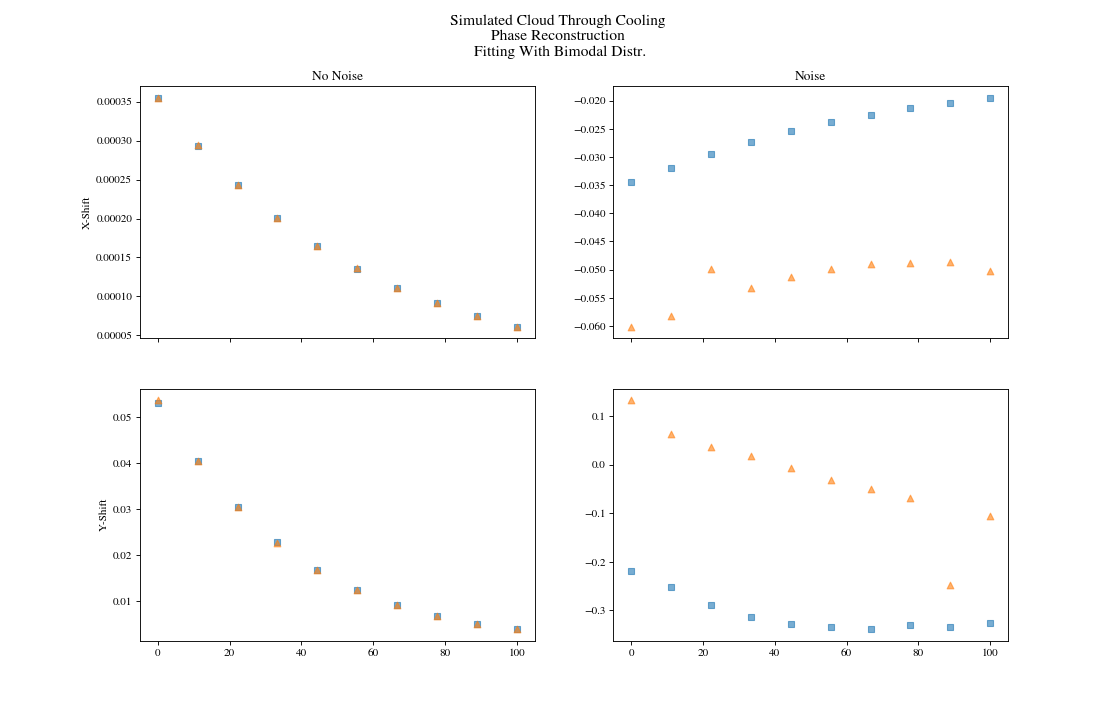

In [53]:
no_noise_x_1 = [el[0]-400 for el in fit1_params[0]]
no_noise_y_1 = [el[1]-400 for el in fit1_params[0]]
noise_x_1 = [el[0]-400 for el in fit1_params[1]]
noise_y_1 = [el[1]-400 for el in fit1_params[1]]

no_noise_x_2 = [el[0]-400 for el in fit2_params[0]]
no_noise_y_2 = [el[1]-400 for el in fit2_params[0]]
noise_x_2 = [el[0]-400 for el in fit2_params[1]]
noise_y_2 = [el[1]-400 for el in fit2_params[1]]


fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 9))

ax[0][0].set_title("No Noise")
ax[0][1].set_title("Noise")
ax[0][0].set_ylabel("X-Shift")
ax[1][0].set_ylabel("Y-Shift")

ax[0][0].scatter(np.linspace(0, 100, 10), no_noise_x_1, c='C0', marker="s", alpha=0.6)
ax[0][0].scatter(np.linspace(0, 100, 10), no_noise_x_2, c='C1', marker="^", alpha=0.6)

ax[0][1].scatter(np.linspace(0, 100, 10), noise_x_1, c='C0', marker="s", alpha=0.6)
ax[0][1].scatter(np.linspace(0, 100, 10), noise_x_2, c='C1', marker="^", alpha=0.6)

ax[1][0].scatter(np.linspace(0, 100, 10), no_noise_y_1, c='C0', marker="s", alpha=0.6)
ax[1][0].scatter(np.linspace(0, 100, 10), no_noise_y_2, c='C1', marker="^", alpha=0.6)

ax[1][1].scatter(np.linspace(0, 100, 10), noise_y_1, c='C0', marker="s", alpha=0.6)
ax[1][1].scatter(np.linspace(0, 100, 10), noise_y_2, c='C1', marker="^", alpha=0.6)

# ax[0][1].set_ylim([295-300, 305-300])
# ax[1][1].set_ylim([200-300, 400-300])

# ax[0][0].set_ylim([299-300, 301-300])
# ax[1][0].set_ylim([200-300, 400-300])

for ax in fig.axes:
    ax.ticklabel_format(style='plain')    # to prevent scientific notation.

fig.suptitle("Simulated Cloud Through Cooling \nPhase Reconstruction \nFitting With Bimodal Distr.", fontsize=14)
    
plt.show()

#### Displacement Due to MTF

In [9]:
size = (500, 500)
T = 10e-7
N = 10e6
noise_par = 0.05
x= 0 
z=0
# # noise_noise = np.random.normal(np.mean(atoms), noise_par, atoms.shape)
# cooling_results = evaporative_cooling_simulation(T_init=3e-6, mu_init=1e-30, N_init=10e6, target_T=1e-7, cooling_steps=100)
# # cooling_results = evaporative_cooling_simulation(T_init=1e-7, mu_init=1e-30, N_init=3e6, target_T=1e-7, cooling_steps=100)
# for r, result in enumerate(cooling_results):
#     T = result['T']  
#     N = result['N']

for curvature in range(0, 200, 1):
    result = generate_cloud(T, N)
    image_synth = createSampleImage(shape=size, params_dict=result) * prefactor
    atoms, FS_a = makeInterference(size=size, angle1=3, angle2=-3, condensate=1, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=curvature, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)
    flat, FS_f  = makeInterference(size=size, angle1=3, angle2=-3, condensate=0, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=curvature, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)

    atoms *= np.random.normal(np.mean(atoms), noise_par, atoms.shape)
    flat *= np.random.normal(np.mean(flat), noise_par, atoms.shape)

    cx=25

    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    colors = ['C0', 'C1']
    labels = ['No MTF', 'MTF']
    for i in range(2):
        ang1 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1", x=x, z=z, MTF=i)
        ang2 = HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad2", x=x, z=z, MTF=i)

        ax[i][0].imshow(ang1[cx:-cx, cx:-cx], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')
        ax[i][1].imshow(ang2[cx:-cx, cx:-cx], vmin=-2, vmax=2, cmap="afmhot_r", aspect='auto')

        ax[2][0].plot(ang1[250, cx:-cx], c=colors[i], alpha=0.2, label=labels[i])
        ax[2][1].plot(ang2[250, cx:-cx], c=colors[i], alpha=0.2, label=labels[i])  

        ax[i][2].plot(ang1[250, cx:-cx], c="C0", alpha=0.2, label="OAH1")
        ax[i][2].plot(ang2[250, cx:-cx], c="C1", alpha=0.2, label="OAH2")


    ax[2][0].plot(image_synth[250, cx:-cx], c='k', ls='--', alpha=0.2, label='GT')
    ax[2][1].plot(image_synth[250, cx:-cx], c='k', ls='--', alpha=0.2, label='GT')
    ax[0][2].plot(image_synth[250, cx:-cx], c='k', ls='--', alpha=0.2, label='GT')
    ax[1][2].plot(image_synth[250, cx:-cx], c='k', ls='--', alpha=0.2, label='GT')

    ax[2][0].set_ylim([0 - image_synth[250, cx:-cx].max()*0.2, image_synth[250, cx:-cx].max()*1.2])
    ax[2][1].set_ylim([0 - image_synth[250, cx:-cx].max()*0.2, image_synth[250, cx:-cx].max()*1.2])
    ax[0][2].set_ylim([0 - image_synth[250, cx:-cx].max()*0.2, image_synth[250, cx:-cx].max()*1.2])
    ax[1][2].set_ylim([0 - image_synth[250, cx:-cx].max()*0.2, image_synth[250, cx:-cx].max()*1.2])

    ax[2][0].legend()
    ax[2][1].legend()
    ax[0][2].legend()
    ax[1][2].legend()

    ax[0][0].set_title("OAH1", fontsize=12)
    ax[0][1].set_title("OAH2", fontsize=12)
    ax[0][0].set_ylabel("NO MTF", fontsize=12)
    ax[1][0].set_ylabel("MTF", fontsize=12)

    for spine in ax[2][2].spines.values():
        spine.set_visible(False)

    for ax in fig.axes:
        ax.set_yticks([])
        ax.set_xticks([])

    fig.suptitle(f"-- PHASE RECONSTRUCTION -- \nT = {round(T * 1e6, 2)} uK, N = {round(N / 1e6, 2)} M \ncurvature = {curvature}\n", fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/curvature/{str(curvature).zfill(5)}.png")
    plt.close()
    clear_output()


Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
(1000, 1000) (1000, 1000)
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
(1000, 1000) (1000, 1000)


<IPython.core.display.Javascript object>


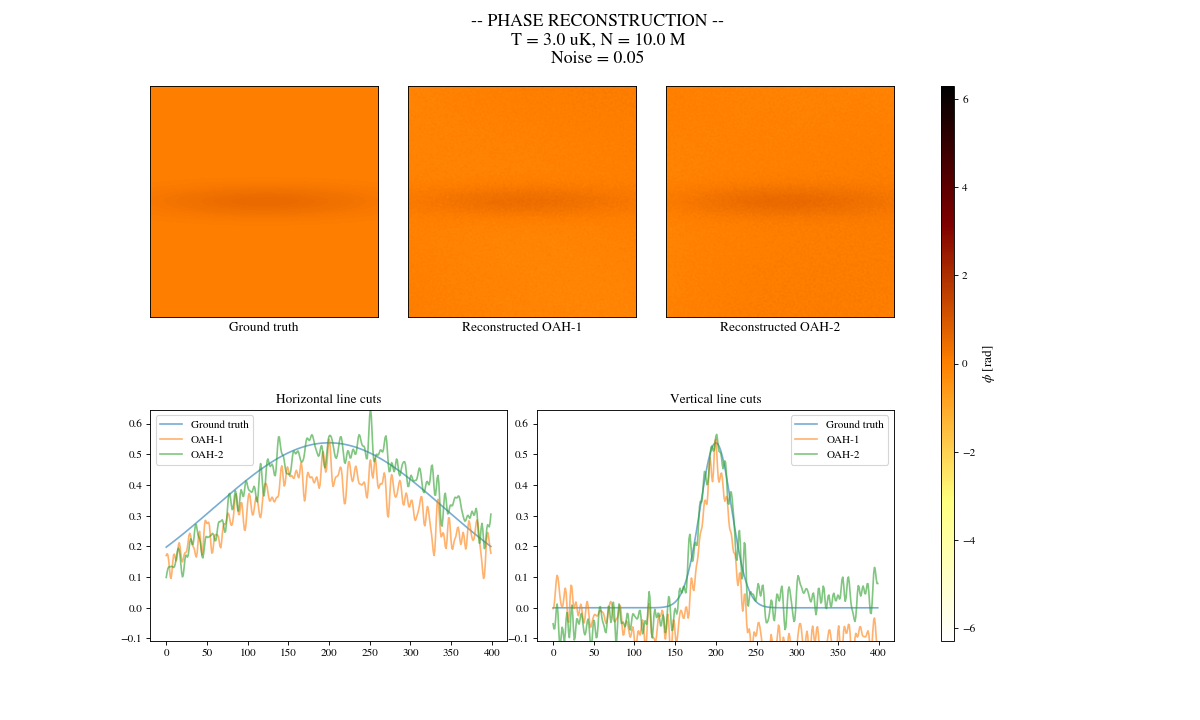

In [12]:
T = 3e-6
N = 10e6
size = (1000, 1000)
noise = True
noise_par = 0.05


cloud_params = generate_cloud(T, N)

image_synth = createSampleImage(shape=size, params_dict=cloud_params, rand=False, norm_dens=False)
image_synth = prefactor * image_synth

T = cloud_params['T']  # Convert temperature to microkelvin
N = cloud_params['N']  # Convert particle number to millions

# Generate Interference Pattern
atoms, FS_a = makeInterference(size=size, angle1=3, angle2=-3, condensate=1, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=0, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)
flat, FS_f  = makeInterference(size=size, angle1=3, angle2=-3, condensate=0, T=T, N=N, curvature_probe=0.1, curvature1=10, curvature2=0, windowtype="tukey", windowalpha=0.5, ref_crosstalk=True)

if noise: 
    ## add noise 
    atoms = atoms * np.random.normal(np.mean(atoms), noise_par, atoms.shape)
    flat = flat * np.random.normal(np.mean(flat), noise_par, flat.shape)

# Process The Interference Pattern
ang1 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad1", x=10, z=1)
ang2 = -HI_refocus_synthetic(atoms, flat, dz_focus=0.000, quad="quad3", x=10, z=1)

# HI_refocus_synthetic(atoms, flat, dz_focus, quad="quad1", x=None, z=None, indices=None, edge_x=10, edge_z=80):


# Cut the images
cut_edgex = 200 # size[0]//2 - 50
cut_edgey = 200 # size[1]//2 - 50
gt = image_synth[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
rec1 = ang1[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]
rec2 = ang2[size[0]//2-cut_edgex:size[0]//2+cut_edgex, size[1]//2-cut_edgey:size[1]//2+cut_edgey]

# Create figure and gridspec layout
fig = plt.figure(figsize=(15, 9))
gs = gridspec.GridSpec(2, 6, height_ratios=[1, 1], hspace=0.4, wspace=0.3)

# Top row: images
ax_img_gt = fig.add_subplot(gs[0, 0:2])
ax_img_rec1 = fig.add_subplot(gs[0, 2:4])
ax_img_rec2 = fig.add_subplot(gs[0, 4:6])

# Bottom row: combined plots
ax_linecuts = fig.add_subplot(gs[1, 0:3])  # Spanning two columns
ax_transposed = fig.add_subplot(gs[1, 3:6])  # Single column for transposed cuts

# Plot images
im = ax_img_gt.imshow(gt, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
ax_img_rec1.imshow(rec1, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
ax_img_rec2.imshow(rec2, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')

# Titles for images
ax_img_gt.set_xlabel("Ground truth", fontsize=12)
ax_img_rec1.set_xlabel("Reconstructed OAH-1", fontsize=12)
ax_img_rec2.set_xlabel("Reconstructed OAH-2", fontsize=12)

# Remove ticks from image axes
for ax in [ax_img_gt, ax_img_rec1, ax_img_rec2]:
    ax.set_xticks([])
    ax.set_yticks([])

# Plot all line cuts (horizontal) on one subplot
ax_linecuts.plot(gt[cut_edgex], label="Ground truth", color="C0", alpha=0.6)
ax_linecuts.plot(rec1[cut_edgex], label="OAH-1", color="C1", alpha=0.6)
ax_linecuts.plot(rec2[cut_edgex], label="OAH-2", color="C2", alpha=0.6)
ax_linecuts.set_title("Horizontal line cuts")
ax_linecuts.legend()

# Plot all transposed line cuts (vertical) on another subplot
ax_transposed.plot(gt.T[cut_edgey], label="Ground truth", color="C0", alpha=0.6)
ax_transposed.plot(rec1.T[cut_edgey], label="OAH-1", color="C1", alpha=0.6)
ax_transposed.plot(rec2.T[cut_edgey], label="OAH-2", color="C2", alpha=0.6)
ax_transposed.set_title("Vertical line cuts")
ax_transposed.legend()

# Overall title
ax_transposed.set_ylim([0-gt.max()*0.2, gt.max()*1.2])
ax_linecuts.set_ylim([0-gt.max()*0.2, gt.max()*1.2])

cbar = plt.colorbar(im, ax=[ax_img_gt, ax_img_rec1, ax_img_rec2, ax_linecuts, ax_transposed], aspect=40)
cbar.set_label("$\phi$ [rad]", rotation=90, fontsize=12)

fig.suptitle(f"-- PHASE RECONSTRUCTION -- \nT = {round(T * 1e6, 2)} uK, N = {round(N / 1e6, 2)} M \nNoise = {noise_par} \n", fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


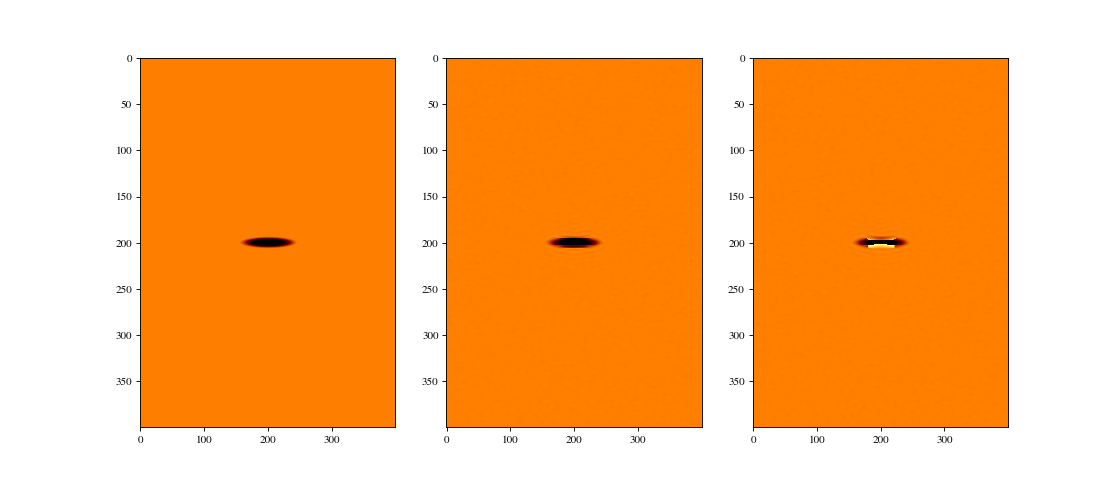

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

pic1 = [unwrap_phase(row) for row in rec1]
pic2 = unwrap_phase(rec1) # [unwrap_phase(row) for row in pic1]


ax[0].imshow(gt, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
ax[1].imshow(pic1, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')
ax[2].imshow(pic2, vmin=-2*np.pi, vmax=2*np.pi, cmap="afmhot_r", aspect='auto')


plt.show()

Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
Using the new box cutter
------ r='quad1' ------
(array([220]), array([194]))
(1000, 1000) (1000, 1000)
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
Using the new box cutter
------ r='quad3' ------
(array([780]), array([194]))
(1000, 1000) (1000, 1000)


<IPython.core.display.Javascript object>


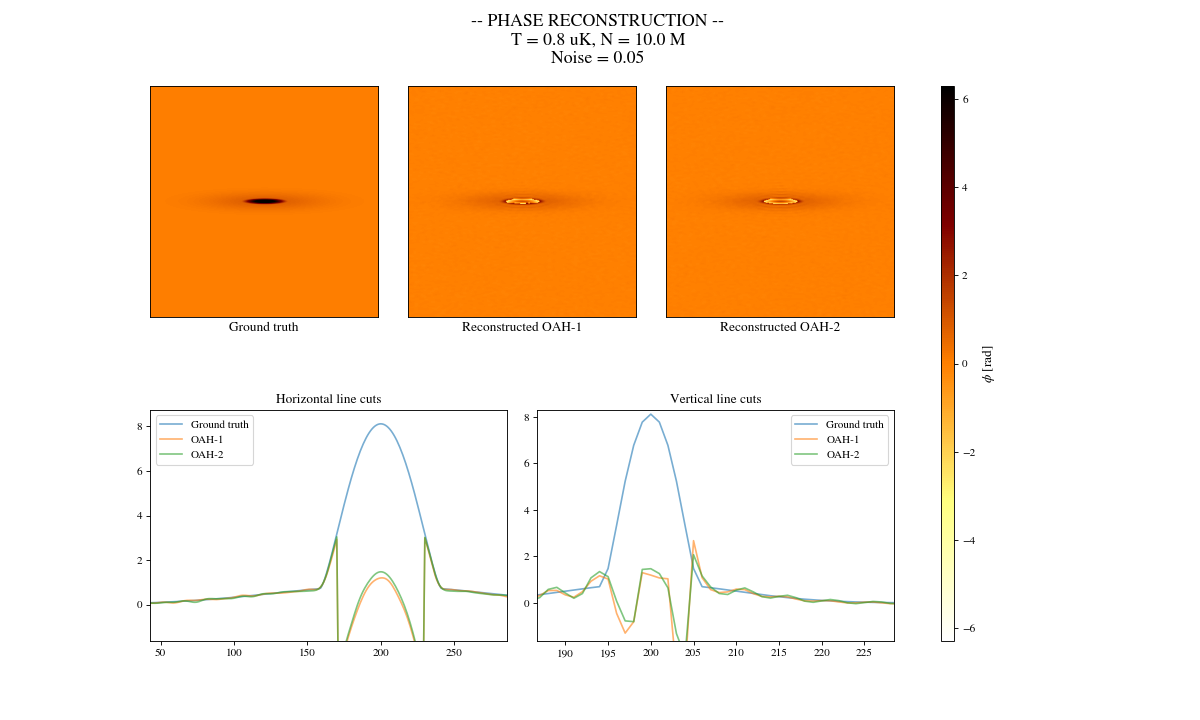

In [81]:
# for ang2 in np.linspace(0, 10, 101):
# size = (500, 500)
T=8e-7
N=10e6

# atoms, FS_a = makeInterference(size=size, 
#                                angle1=3, angle2=-3, 
#                                condensate=1, T=T, N=N, 
#                                curvature_probe=0.1, curvature1=10, curvature2=10, 
#                                windowtype="none", windowalpha=0.9, 
#                                ref_crosstalk=False)    

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# #     ax[0].imshow(atoms[400:600, 400:600], cmap='afmhot_r', vmin=0, vmax=3)
# ax[0].imshow(atoms, cmap='afmhot_r', vmin=0, vmax=3)
# ax[1].imshow(abs(FS_a), cmap='afmhot_r', vmin=-1000, vmax=1000)

#     plt.savefig(f"/home/bec_lab/Desktop/imgs/SOAH/BackgroundNormalization/fft_peak_angle/{str(round(ang2*100)).zfill(3)}.png")
plt.show()

cloud_params = generate_cloud(T, N)
previewReconstruction(cloud_params, size, noise=noise, noise_par=noise_par)
    

In [744]:
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

def low_pass_filter(image, cutoff):
    """
    Apply a low-pass filter to remove higher-order frequencies in a 2D array.
    
    Parameters:
        image (numpy.ndarray): The input 2D array (image).
        cutoff (float): The cutoff frequency (0 < cutoff < 0.5) as a fraction of the maximum frequency.
        
    Returns:
        numpy.ndarray: The filtered 2D array.
    """
    # Step 1: Compute the 2D Fourier Transform of the input image
    f_transform = fft2(image)
    f_transform_shifted = fftshift(f_transform)  # Shift zero frequency component to center
    
    # Step 2: Create a low-pass filter mask
    rows, cols = image.shape
    center_row, center_col = rows // 2, cols // 2
    radius = int(min(rows, cols) * cutoff)
    
    y, x = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    mask = distance_from_center <= radius
    
    # Step 3: Apply the mask to the shifted Fourier Transform
    filtered_shifted = f_transform_shifted * mask
    
    # Step 4: Compute the inverse Fourier Transform to get the filtered image
    filtered_transform = ifftshift(filtered_shifted)  # Shift back
    filtered_image = np.abs(ifft2(filtered_transform))  # Inverse FFT and take the magnitude
    
    return filtered_image


<IPython.core.display.Javascript object>


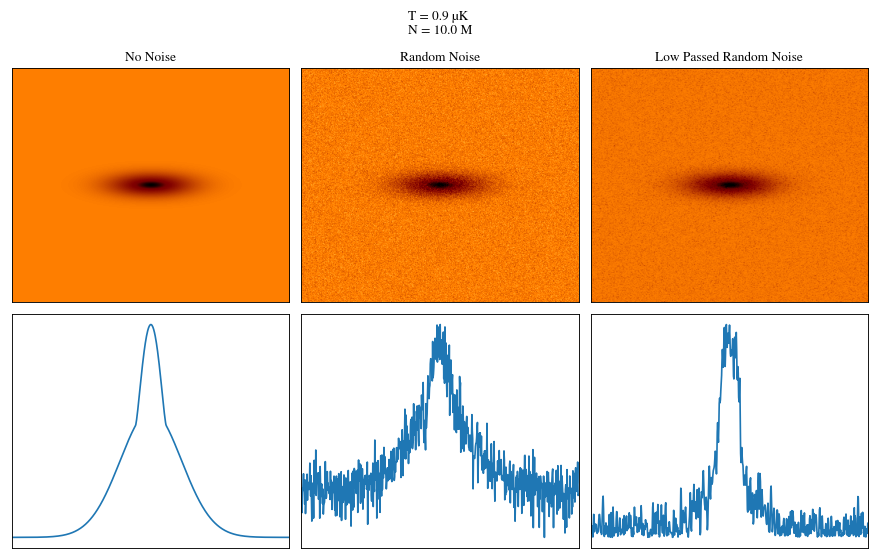

In [801]:
cloud_params = generate_cloud(T=0.9e-6, N=10e6)
image_synth = createSampleImage(shape=(300, 700), params_dict=cloud_params, rand=False)
temp_uK = round(cloud_params['T'] * 1e6, 2)  # Convert temperature to microkelvin
N_million = round(cloud_params['N'] / 1e6, 2)  # Convert particle number to millions

image_synth_noise = image_synth + np.random.normal(np.mean(image_synth), 0.1, image_synth.shape)

fig, ax = plt.subplots(2, 3, figsize=(11,7), sharex=True)
fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M")

ax[0][0].imshow(image_synth, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
ax[1][0].plot(image_synth[150])

ax[0][1].imshow(image_synth_noise, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
ax[1][1].plot(image_synth_noise[150])

image_synth_filt_noise = image_synth + low_pass_filter(np.random.normal(np.mean(image_synth), 0.1, image_synth.shape), cutoff=0.5)
ax[0][2].imshow(image_synth_filt_noise, vmin=-1, vmax=1, cmap="afmhot_r", aspect='auto')
ax[1][2].plot(filt_image[150])

ax[0][0].set_title("No Noise")
ax[0][1].set_title("Random Noise")
ax[0][2].set_title("Low Passed Random Noise")

for ax in fig.axes:
    ax.set_xticks([])    
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


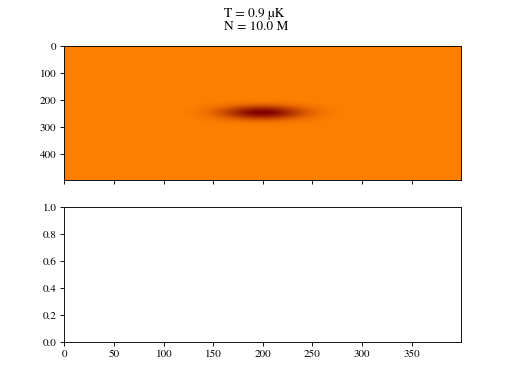

In [803]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M")
ax[0].imshow(gaussian_matrix, cmap="afmhot_r", aspect='auto', vmin=-2, vmax=2)

plt.show()

<IPython.core.display.Javascript object>


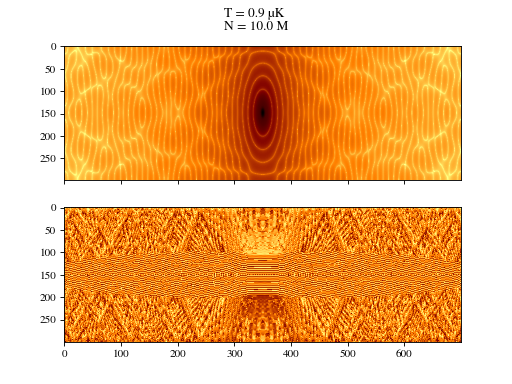

In [795]:
fft_is = np.fft.fftshift(np.fft.fft2(image_synth))
inv = np.angle(np.fft.ifft2(elliptical_mask_with_taper(fft_is, alpha=0.9, taper_fraction=0.1)))

fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle(f"T = {temp_uK} µK \nN = {N_million} M")
ax[0].imshow(np.log(abs(fft_is)), cmap="afmhot_r", aspect='auto')
ax[1].imshow(inv, cmap="afmhot_r", aspect='auto')

plt.show()

In [671]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tukey

def elliptical_mask_with_taper(array, alpha=0.5, taper_fraction=0.5):
    """
    Cut out an ellipse with tapered edges from the center of a 2D array.
    
    Parameters:
        array (2D np.array): Input 2D array.
        alpha (float): Tukey window shape parameter (0: rectangular, 1: Hann window).
        taper_fraction (float): Fraction of the ellipse edge to be tapered.
    
    Returns:
        np.array: 2D array with elliptical mask applied and tapered edges.
    """
    h, w = array.shape
    center_x, center_y = w // 2, h // 2
    
    # Create meshgrid centered at (0, 0)
    x = np.arange(w) - center_x
    y = np.arange(h) - center_y
    xv, yv = np.meshgrid(x, y)

    # Define ellipse equation: (x/a)^2 + (y/b)^2 = 1
    a, b = w // 4, h // 4  # Semi-major and semi-minor axes (adjust as needed)
    ellipse = (xv / a)**2 + (yv / b)**2 <= 1

    # Create Tukey window for tapering
    tukey_x = tukey(2 * a, taper_fraction)
    tukey_y = tukey(2 * b, taper_fraction)
    
    # Apply Tukey window along each axis
    tukey_2d = np.outer(tukey_y, tukey_x)
    
    # Center the Tukey window on the array
    tukey_window = np.zeros_like(array, dtype=float)
    start_x, start_y = center_x - a, center_y - b
    tukey_window[start_y:start_y + 2 * b, start_x:start_x + 2 * a] = tukey_2d
    
    # Apply tapered ellipse mask to the array
    result = array * ellipse * tukey_window
    return result

# Example usage
array = np.ones((300, 400))  # Example 2D array
tapered_ellipse = elliptical_mask_with_taper(array, alpha=0.5, taper_fraction=0.5)

# Plot the result
plt.imshow(tapered_ellipse, cmap='gray')
plt.title("Tapered Ellipse Mask")
plt.colorbar()
plt.show()


### Machine Learning

In [149]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Load and prepare dataset
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, cv2.IMREAD_GRAYSCALE))
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize pixel values
            images.append(img)
    return np.array(images)


# Load clean images
clean_images = load_images_from_folder('path_to_clean_images')
noisy_images = clean_images + np.random.normal(0, 0.1, clean_images.shape)  # Add noise

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(noisy_images, clean_images, test_size=0.2, random_state=42)

# Reshape data to fit model input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Build the autoencoder model
input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Denoise test images
denoised_images = autoencoder.predict(X_test)

# Plot original vs denoised images
n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original noisy image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title("Noisy")
    
    # Display denoised image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(denoised_images[i].reshape(128, 128), cmap='gray')
    plt.title("Denoised")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_clean_images'